In [153]:
import math
import numpy as np
from os import listdir
from typing import Dict, Tuple, Set, List
from tqdm import tqdm
import matplotlib.pyplot as plt

In [53]:
def n_grams(words, n):
    res = []
    if len(words) < n:
        phrase = ""
        for j in range(len(words)):
            phrase += words[j]
            if j != len(words) - 1:
                 phrase += " "
        res.append(phrase)
        return res

    for i in range(len(words) - n):
        cur_phrase = ""
        for j in range(n):
            cur_phrase += words[i + j]
            if j != n - 1:
                cur_phrase += " "
        res.append(cur_phrase)
    return res
        

class Email(object):
    def __init__(self, filename, subject, body):
        self.filename = filename
        self.subject = subject
        self.body = body
    
    def is_spam(self):
        return "spmsg" in self.filename
    
    def is_legit(self):
        return not self.is_spam()
    
    def subject_n_grams(self, n):
        return n_grams(self.subject, n)
    
    def body_n_grams(self, n):
        return n_grams(self.body, n)
        

def file_names(dirname):
    return [ dirname + "/" + filename for filename in listdir(dirname)]

def read_file(filename):
    file = open(filename, "r")
    subject = file.readline().split()[1:]
    file.readline()
    body = file.readline().split()
    return Email(filename, subject, body)

In [54]:
alphas = [1e-6, 1e-5, 1e-4]
ns = [1, 2, 3]
lambdas = [10 ** x for x in range(55)]
lambda_spam = 1

LEGIT_CLASS = 0
SPAM_CLASS = 1
PARTS_NUM = 10
EPS = 1e-10
classes = [LEGIT_CLASS, SPAM_CLASS]


In [55]:
class Stat(object):
    def __init__(self, classes_num: Dict[int, int], all_phrases: Set[str],
                     phrase_in_class_k: Dict[Tuple[str, int], int]):
        self.classes_num = classes_num
        self.all_phrases = all_phrases
        self.phrase_in_class_k = phrase_in_class_k


def calculate_likelihood_probabilities(alpha: float, stat: Stat) -> Dict[Tuple[str, int], Tuple[float, float]]:
    likelihood_probabilities: Dict[Tuple[str, int], Tuple[float, float]] = {}
    for phrase in stat.all_phrases:
        for cl in classes:
            count = 0
            if (phrase, cl) in stat.phrase_in_class_k:
                count = stat.phrase_in_class_k[(phrase, cl)]
            numerator = count + alpha + 0.000
            denominator = stat.classes_num[cl] + alpha * 2 + 0.0000
            likelihood_probabilities[(phrase, cl)] = (numerator, denominator)
    return likelihood_probabilities

In [56]:
def get_train_data(dir_index: int):
    emails = []
    dirname = "part" + str(dir_index)
    filenames = file_names(dirname)
    for filename in filenames:
        email = read_file(filename)
        emails.append(email)
    return emails

def train_data_to_local_stat(emails: List[Email], n: int):
    classes_num = {}
    classes_num[SPAM_CLASS] = 0
    classes_num[LEGIT_CLASS] = 0
    all_phrases: Set[str] = set() 
    phrase_in_class_k: Dict[Tuple[str, int], int] = {}
    for email in emails:
        clazz = LEGIT_CLASS
        if email.is_spam():
            clazz = SPAM_CLASS
        classes_num[clazz] += 1
        subject_n_grams = email.subject_n_grams(n)
        body_n_grams = email.body_n_grams(n)
        unique_phrases = set(subject_n_grams + body_n_grams)
        for phrase in unique_phrases:
            all_phrases.add(phrase)
            if (phrase, clazz) in phrase_in_class_k:
                phrase_in_class_k[(phrase, clazz)] += 1
            else:
                phrase_in_class_k[(phrase, clazz)] = 1
    return Stat(classes_num, all_phrases, phrase_in_class_k)        


In [57]:
parts: List[List[Email]] = []
for part in range(1, PARTS_NUM + 1):
    if part == 3 or part == 5 or part == 7:
        continue
    parts.append(get_train_data(part))

In [58]:
def predict(stat: Stat, likelihood_probabilities, email: Email, lamda_legit, n: int):
    lambdas = [0, 0]
    lambdas[LEGIT_CLASS] = lambda_legit
    lambdas[SPAM_CLASS] = lambda_spam
    this_phrases = set(email.subject_n_grams(n) + email.body_n_grams(n))
    num = [0] * 2
    for cl in classes:
        this_num = 0
        this_num += math.log(lambdas[cl] * (EPS + stat.classes_num[cl] / n))
        for phrase in stat.all_phrases.difference(this_phrases):
            this_num += math.log(1 - (likelihood_probabilities[(phrase, cl)][0] / likelihood_probabilities[(phrase, cl)][1]))
        for phrase in this_phrases.intersection(stat.all_phrases):
            this_num += math.log(likelihood_probabilities[(phrase, cl)][0] / likelihood_probabilities[(phrase, cl)][1])
        num[cl] = this_num
    max_num = max(num)
    snd = 0
    for ln_pr in num:
        snd += math.exp(ln_pr - max_num)
    snd = math.log(snd) + max_num
    spam_probability = math.exp(num[SPAM_CLASS] - snd)
    legit_probability = math.exp(num[LEGIT_CLASS] - snd)
    if spam_probability > legit_probability:
        return SPAM_CLASS
    else:
        return LEGIT_CLASS


def model(alpha, n, lambda_legit):
    accuracy = 0
    lost_legits = []
    
    for test_index in range(len(parts)):
        train_emails: List[Email] = []
        for train_i in range(len(parts)):
            if train_i == test_index:
                continue
            train_emails.extend(parts[train_i])
        train_stat = train_data_to_local_stat(train_emails, n)
        likelihood_probabilities = calculate_likelihood_probabilities(alpha, train_stat)
        test_emails: List[Email] = []
        test_emails.extend(parts[test_index])
        for test_email in test_emails:
            res = predict(train_stat, likelihood_probabilities, test_email, lambda_legit, n)
            if res == SPAM_CLASS and test_email.is_spam() or res == LEGIT_CLASS and test_email.is_legit():
                accuracy += 1
#             else:
#                 print(f'ERROR: {res} for {test_email.filename}')
            if res == SPAM_CLASS and test_email.is_legit():
                lost_legits.append(test_email.filename)
    return accuracy, lost_legits

In [59]:
all_size = 0
for part in parts:
    all_size += len(part)
best_alpha = -1
best_lambda = -1
best_accuracy = -1
for alpha in alphas:
        for lambda_legit in lambdas:
            accuracy, lost_legits = model(alpha, 1, lambda_legit)
            accuracy = accuracy / all_size
            print(f'parameters alpha={alpha}, n={1}, lambda_legit={lambda_legit}: accuracy={accuracy}, lost legits={len(lost_legits)}')
            if len(lost_legits) == 0 and accuracy > best_accuracy:
                best_accuracy = accuracy
                best_alpha = alpha
                best_lambda = lambda_legit
print(f'Best alpha: {best_alpha}')
print(f'Best lambda: {best_lambda}')

parameters alpha=1e-06, n=1, lambda_legit=1: accuracy=0.9698558322411533, lost legits=6
parameters alpha=1e-06, n=1, lambda_legit=10: accuracy=0.9685452162516383, lost legits=6
parameters alpha=1e-06, n=1, lambda_legit=100: accuracy=0.9659239842726082, lost legits=6
parameters alpha=1e-06, n=1, lambda_legit=1000: accuracy=0.9659239842726082, lost legits=5
parameters alpha=1e-06, n=1, lambda_legit=10000: accuracy=0.9646133682830931, lost legits=5
parameters alpha=1e-06, n=1, lambda_legit=100000: accuracy=0.9646133682830931, lost legits=5
parameters alpha=1e-06, n=1, lambda_legit=1000000: accuracy=0.9593709043250328, lost legits=5
parameters alpha=1e-06, n=1, lambda_legit=10000000: accuracy=0.9593709043250328, lost legits=4
parameters alpha=1e-06, n=1, lambda_legit=100000000: accuracy=0.9567496723460026, lost legits=4
parameters alpha=1e-06, n=1, lambda_legit=1000000000: accuracy=0.9554390563564875, lost legits=4
parameters alpha=1e-06, n=1, lambda_legit=10000000000: accuracy=0.952817824

parameters alpha=1e-05, n=1, lambda_legit=100000000000000000000: accuracy=0.9318479685452162, lost legits=3
parameters alpha=1e-05, n=1, lambda_legit=1000000000000000000000: accuracy=0.927916120576671, lost legits=3
parameters alpha=1e-05, n=1, lambda_legit=10000000000000000000000: accuracy=0.9252948885976409, lost legits=2
parameters alpha=1e-05, n=1, lambda_legit=100000000000000000000000: accuracy=0.9226736566186108, lost legits=2
parameters alpha=1e-05, n=1, lambda_legit=1000000000000000000000000: accuracy=0.9174311926605505, lost legits=2
parameters alpha=1e-05, n=1, lambda_legit=10000000000000000000000000: accuracy=0.9161205766710354, lost legits=2
parameters alpha=1e-05, n=1, lambda_legit=100000000000000000000000000: accuracy=0.9121887287024901, lost legits=2
parameters alpha=1e-05, n=1, lambda_legit=1000000000000000000000000000: accuracy=0.90956749672346, lost legits=2
parameters alpha=1e-05, n=1, lambda_legit=10000000000000000000000000000: accuracy=0.9069462647444299, lost legi

parameters alpha=0.0001, n=1, lambda_legit=1000000000000000000000000000000000000: accuracy=0.8597640891218873, lost legits=1
parameters alpha=0.0001, n=1, lambda_legit=10000000000000000000000000000000000000: accuracy=0.8584534731323722, lost legits=1
parameters alpha=0.0001, n=1, lambda_legit=100000000000000000000000000000000000000: accuracy=0.854521625163827, lost legits=1
parameters alpha=0.0001, n=1, lambda_legit=1000000000000000000000000000000000000000: accuracy=0.854521625163827, lost legits=1
parameters alpha=0.0001, n=1, lambda_legit=10000000000000000000000000000000000000000: accuracy=0.854521625163827, lost legits=1
parameters alpha=0.0001, n=1, lambda_legit=100000000000000000000000000000000000000000: accuracy=0.8505897771952818, lost legits=1
parameters alpha=0.0001, n=1, lambda_legit=1000000000000000000000000000000000000000000: accuracy=0.8466579292267365, lost legits=1
parameters alpha=0.0001, n=1, lambda_legit=10000000000000000000000000000000000000000000: accuracy=0.8427260

In [60]:
print(f'Best alpha: {best_alpha}')
print(f'Best lambda: {best_lambda}')
print(f'Best accuracy: {best_accuracy}')

Best alpha: 1e-06
Best lambda: 100000000000000000000000000000000000000000000000000
Best accuracy: 0.8519003931847968


In [68]:
# check n = 2, n = 3
tr, lost_legits = model(1e-6, 2, 1e30)
accuracy = tr/all_size
print(f'Accuracy for n=2: {accuracy}. Lost legits: {len(lost_legits)}')

Accuracy for n=2: 0.9370904325032765. Lost legits: 3


In [69]:
tr, lost_legits = model(1e-6, 3, 1e30)
accuracy = tr/all_size
print(f'Accuracy for n=3: {accuracy}. Lost legits: {len(lost_legits)}')

Accuracy for n=3: 0.9043250327653998. Lost legits: 1


In [97]:
ys = []
xs = []
for lambda_legit in tqdm(lambdas):
    tr, _ = model(best_alpha, 1, lambda_legit)
    accuracy = tr/all_size
    xs.append(lambda_legit)
    ys.append(accuracy)
    if lambda_legit == best_lambda:
        break
    xs.append(lambda_legit)
    ys.append(accuracy)

 91%|█████████ | 50/55 [26:56<02:41, 32.34s/it]


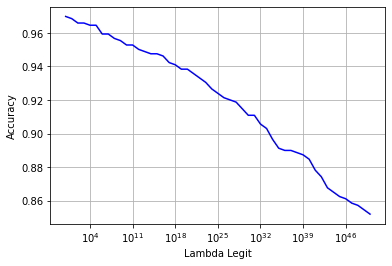

In [101]:
plt.xscale('log')
plt.plot(xs, ys, 'b')
plt.ylabel('Accuracy')
plt.xlabel('Lambda Legit')
plt.grid()
plt.show()

In [139]:
def predict2(stat: Stat, likelihood_probabilities, email: Email, lamda_legit, n: int):
    lambdas = [0, 0]
    lambdas[LEGIT_CLASS] = lambda_legit
    lambdas[SPAM_CLASS] = lambda_spam
    this_phrases = set(email.subject_n_grams(n) + email.body_n_grams(n))
    num = [0] * 2
    for cl in classes:
        this_num = 0
        this_num += math.log(lambdas[cl] * (EPS + stat.classes_num[cl] / n))
        for phrase in stat.all_phrases.difference(this_phrases):
            this_num += math.log(1 - (likelihood_probabilities[(phrase, cl)][0] / likelihood_probabilities[(phrase, cl)][1]))
        for phrase in this_phrases.intersection(stat.all_phrases):
            this_num += math.log(likelihood_probabilities[(phrase, cl)][0] / likelihood_probabilities[(phrase, cl)][1])
        num[cl] = this_num
    max_num = max(num)
    snd = 0
    for ln_pr in num:
        snd += math.exp(ln_pr - max_num)
    snd = math.log(snd) + max_num
    spam_probability = math.exp(num[SPAM_CLASS] - snd)
    legit_probability = math.exp(num[LEGIT_CLASS] - snd)
    return legit_probability, spam_probability

alpha = 1e-6
lambda_legit = 1e50
n = 1
y_true = []
y_target = []
for test_index in range(len(parts)):
    train_emails: List[Email] = []
    for train_i in range(len(parts)):
        if train_i == test_index:
            continue
        train_emails.extend(parts[train_i])
    train_stat = train_data_to_local_stat(train_emails, n)
    likelihood_probabilities = calculate_likelihood_probabilities(alpha, train_stat)
    test_emails: List[Email] = []
    test_emails.extend(parts[test_index])
    for test_email in test_emails:
        leg_prob, spam_prob = predict2(train_stat, likelihood_probabilities, test_email, lambda_legit, n)
        if test_email.is_spam():
            y_true.append(SPAM_CLASS)
            y_target.append(leg_prob)
        else:
            y_true.append(LEGIT_CLASS)
            y_target.append(leg_prob)
            

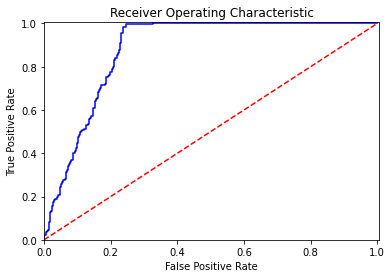

In [152]:
y_all = list(zip(y_true, y_target))
y_all = sorted(y_all, key=lambda x: x[1], reverse=True)
y_true, y_target = zip(*y_all)
y_true = list(y_true)
y_target = list(y_target)
count_spam = 0
count_legit = 0
for ytr in y_true:
    if ytr == SPAM_CLASS:
        count_spam += 1
    else:
        count_legit += 1

points_x = [0]
points_y = [0]
cur_x = 0
cur_y = 0
i = 0

while i < len(y_true):
    j = i
    dy = 0
    dx = 0
    if y_true[j] == LEGIT_CLASS:
        dy += 1
    else:
        dx += 1
    j += 1
    cur_x += dx
    cur_y += dy
    points_x.append(cur_x / count_spam)
    points_y.append(cur_y / count_legit)
    i += j - i

plt.title('Receiver Operating Characteristic')
plt.plot(points_x, points_y, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.005])
plt.ylim([0, 1.005])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()